## Importing Libraries 

In [21]:
import numpy as np
import pandas as pd
import skimage
import skimage.feature
import skimage.viewer
import sys
import PIL
from IPython.core.display import display,HTML
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io
from skimage import color

In [2]:

df = pd.DataFrame([],columns = [])

# your images
images = ['https://images.newscientist.com/wp-content/uploads/2017/08/22171006/gettyimages-154954156.jpg']

df['image'] = images

# convert your links to html tags 
def path_to_image_html(path):
    return '<img src="'+ path + '" width="440" >'

pd.set_option('display.max_colwidth', None)

display(HTML(df.to_html(escape=False ,formatters=dict(image=path_to_image_html))))

,image
0,


## Image Preprocessing

In [3]:
from PIL import Image
# Open the image form working directory
image = Image.open('1.jpg')
# summarize some details about the image
print(image.format)
print(image.size)
print(image.mode)
# show the image


JPEG
(1200, 800)
RGB


In [4]:

# Imported PIL Library from PIL import Image

# Open an Image
def open_image(path):
  newImage = Image.open(path)
  return newImage

# Save Image
def save_image(image, path):
  image.save(path, 'png')
# Create a new image with the given size
def create_image(i, j):
  image = Image.new("RGB", (i, j), "white")
  return image


# Get the pixel from the given image
def get_pixel(image, i, j):
  # Inside image bounds?
  width, height = image.size
  if i > width or j > height:
    return None

  # Get Pixel
  pixel = image.getpixel((i, j))
  return pixel

# Create a Grayscale version of the image
def convert_grayscale(image):
  # Get size
  width, height = image.size

  # Create new Image and a Pixel Map
  new = create_image(width, height)
  pixels = new.load()
  # Transform to grayscale
  for i in range(width):
    for j in range(height):
      # Get Pixel
      pixel = get_pixel(image, i, j)

      # Get R, G, B values (This are int from 0 to 255)
      red =   pixel[0]
      green = pixel[1]
      blue =  pixel[2]

      # Transform to grayscale
      gray = (red * 0.299) + (green * 0.587) + (blue * 0.114)

      # Set Pixel in new image
      pixels[i, j] = (int(gray), int(gray), int(gray))

  # Return new image
  return new


# Create a Half-tone version of the image
def convert_halftoning(image):
  # Get size
  width, height = image.size

  # Create new Image and a Pixel Map
  new = create_image(width, height)
  pixels = new.load()

  # Transform to half tones
  for i in range(0, width, 2):
    for j in range(0, height, 2):
      # Get Pixels
      p1 = get_pixel(image, i, j)
      p2 = get_pixel(image, i, j + 1)
      p3 = get_pixel(image, i + 1, j)
      p4 = get_pixel(image, i + 1, j + 1)

       # Transform to grayscale
      gray1 = (p1[0] * 0.299) + (p1[1] * 0.587) + (p1[2] * 0.114)
      gray2 = (p2[0] * 0.299) + (p2[1] * 0.587) + (p2[2] * 0.114)
      gray3 = (p3[0] * 0.299) + (p3[1] * 0.587) + (p3[2] * 0.114)
      gray4 = (p4[0] * 0.299) + (p4[1] * 0.587) + (p4[2] * 0.114)

       # Saturation Percentage
      sat = (gray1 + gray2 + gray3 + gray4) / 4

       # Draw white/black depending on saturation
      if sat > 223:
         pixels[i, j]         = (255, 255, 255) # White
         pixels[i, j + 1]     = (255, 255, 255) # White
         pixels[i + 1, j]     = (255, 255, 255) # White
         pixels[i + 1, j + 1] = (255, 255, 255) # White
      elif sat > 159:
         pixels[i, j]         = (255, 255, 255) # White
         pixels[i, j + 1]     = (0, 0, 0)       # Black
         pixels[i + 1, j]     = (255, 255, 255) # White
         pixels[i + 1, j + 1] = (255, 255, 255) # White
      elif sat > 95:
         pixels[i, j]         = (255, 255, 255) # White
         pixels[i, j + 1]     = (0, 0, 0)       # Black
         pixels[i + 1, j]     = (0, 0, 0)       # Black
         pixels[i + 1, j + 1] = (255, 255, 255) # White
      elif sat > 32:
         pixels[i, j]         = (0, 0, 0)       # Black
         pixels[i, j + 1]     = (255, 255, 255) # White
         pixels[i + 1, j]     = (0, 0, 0)       # Black
         pixels[i + 1, j + 1] = (0, 0, 0)       # Black
      else:
         pixels[i, j]         = (0, 0, 0)       # Black
         pixels[i, j + 1]     = (0, 0, 0)       # Black
         pixels[i + 1, j]     = (0, 0, 0)       # Black
         pixels[i + 1, j + 1] = (0, 0, 0)       # Black

  # Return new image
  return new


# Return color value depending on quadrant and saturation
def get_saturation(value, quadrant):
  if value > 223:
    return 255
  elif value > 159:
    if quadrant != 1:
      return 255

    return 0
  elif value > 95:
    if quadrant == 0 or quadrant == 3:
      return 255

    return 0
  elif value > 32:
    if quadrant == 1:
      return 255

    return 0
  else:
    return 0


# Create a dithered version of the image
def convert_dithering(image):
  # Get size
  width, height = image.size

  # Create new Image and a Pixel Map
  new = create_image(width, height)
  pixels = new.load()

  # Transform to half tones
  for i in range(0, width, 2):
    for j in range(0, height, 2):
      # Get Pixels
      p1 = get_pixel(image, i, j)
      p2 = get_pixel(image, i, j + 1)
      p3 = get_pixel(image, i + 1, j)
      p4 = get_pixel(image, i + 1, j + 1)

      # Color Saturation by RGB channel
      red   = (p1[0] + p2[0] + p3[0] + p4[0]) / 4
      green = (p1[1] + p2[1] + p3[1] + p4[1]) / 4
      blue  = (p1[2] + p2[2] + p3[2] + p4[2]) / 4

      # Results by channel
      r = [0, 0, 0, 0]
      g = [0, 0, 0, 0]
      b = [0, 0, 0, 0]

      # Get Quadrant Color
      for x in range(0, 4):
        r[x] = get_saturation(red, x)
        g[x] = get_saturation(green, x)
        b[x] = get_saturation(blue, x)

      # Set Dithered Colors
      pixels[i, j]         = (r[0], g[0], b[0])
      pixels[i, j + 1]     = (r[1], g[1], b[1])
      pixels[i + 1, j]     = (r[2], g[2], b[2])
      pixels[i + 1, j + 1] = (r[3], g[3], b[3])

  # Return new image
  return new


# Create a Primary Colors version of the image
def convert_primary(image):
  # Get size
  width, height = image.size

  # Create new Image and a Pixel Map
  new = create_image(width, height)
  pixels = new.load()

  # Transform to primary
  for i in range(width):
    for j in range(height):
      # Get Pixel
      pixel = get_pixel(image, i, j)

      # Get R, G, B values (This are int from 0 to 255)
      red =   pixel[0]
      green = pixel[1]
      blue =  pixel[2]

      # Transform to primary
      if red > 127:
        red = 255
      else:
        red = 0
      if green > 127:
        green = 255
      else:
        green = 0
      if blue > 127:
        blue = 255
      else:
        blue = 0

      # Set Pixel in new image
      pixels[i, j] = (int(red), int(green), int(blue))

  # Return new image
  return new


# Main
if __name__ == "__main__":
  # Load Image (JPEG/JPG needs libjpeg to load)
  original = open_image('1.jpg')

  # Example Pixel Color
  print('Color: ' + str(get_pixel(original, 0, 0)))

  # Convert to Grayscale and save
  new = convert_grayscale(original)
  save_image(new, '1_gray.png')

  # Convert to Halftoning and save
  new = convert_halftoning(original)
  save_image(new, '1_half.png')

  # Convert to Dithering and save
  new = convert_dithering(original)
  save_image(new, '1_dither.png')

  # Convert to Primary and save
  new = convert_primary(original)
  save_image(new, '1_primary.png')
    
image_file = Image.open("1.jpg") # open colour image
image_file = image_file.convert('1') # convert image to black and white
image_file.save('1_black&white.png')


Color: (48, 110, 171)


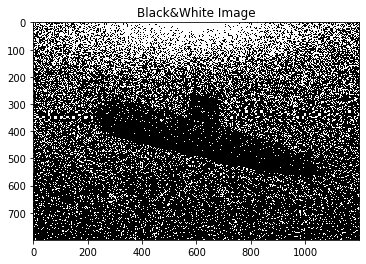

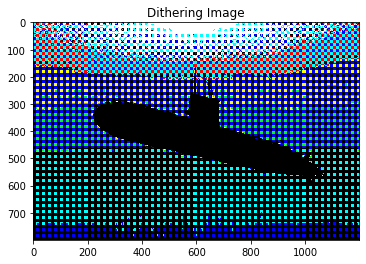

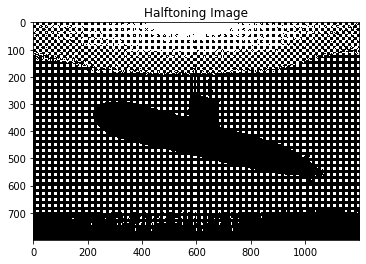

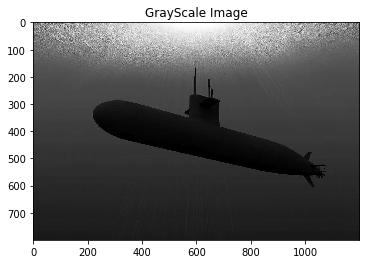

In [5]:

# load image as pixel array
image_blackwhite = open_image('1_black&white.png')
pyplot.imshow(image_blackwhite)
plt.title('Black&White Image')
pyplot.show()

image_dithering = open_image('1_dither.png')
pyplot.imshow(image_dithering)
plt.title('Dithering Image')
pyplot.show()

image_half = open_image('1_half.png')
pyplot.imshow(image_half)
plt.title('Halftoning Image')
pyplot.show()

image_gray = open_image('1_gray.png')
pyplot.imshow(image_gray)
plt.title('GrayScale Image')
pyplot.show()